# HEATWAVE FUNCTION FINAL

## 1 Heatwave Function

In [4]:
#The Core Function
def Heatwave_Function_v5(Dataset,Dates_DataFrame,CDP_Matrix,Heatwave_Detail= True,Percentile = 85,window = 7,CDP_start_end_years = [1961,1990]):
    '''
    Parameters
    ----------
    Dataset : DataFrame
        A Tmax and Tmin Dataset that has index as numbers and not datetime.
        #It should be in column form date_name, Tmax, Tmin
        datetime should be in format Year-Month-Day Already
        
    Dates_DataFrame : DataFrame
        This is just a DataFrame that has the dates of 366 days ready to be used where needed. 
    
    CDP_Matrix : Array
        If set to [] then the functions and arguements relating to the CDP are irrelevant to the function by inputs should be
        for the function to work properly.
    
    Heatwave_Detail : True or False
        If True is selected the heatwaves will be expanded into more detail.
        
    Percentile : Integer/Decimal
        A number that is used for the CDP, it calculates the value where the temperature must exceed to be in 
        that x percentile
    
    
    window : Integer
        Number of days either side of the day in focus that is used to calculate the percentile value in the CDP
    
    CDP_start_end_years : array of 2
        The years when the CDP should be calculated. Forms the basis of how many heatwaves we get
    
    RETURNS
    -----------------
    
    heatwaves : DataFrame
        The heatwave with all the relevant information.
        
    CDP : DataFrame
        Calendar Day Percentile so this can be inputted in the function again and save time.
    
    '''
    #Extract Columns
    Column_Dataset = Dataset.columns
        #For the calendar day percentile (CDP) function this dataset needs to be expanded to dataset_exp
    Dataset_Exp = Date_Splitter(Dataset)
    
    #Now calculate the Calender Day Percentiles for tmax and tmin if required.
    if (len(CDP_Matrix) == 0):
        #Now to calculate the CDP for Max and Min Temperatures
        CDP_Max = Calendar_Day_Percentile(Dataset_Exp,Percentile,
                                      Column_Dataset[1],
                                      CDP_start_end_years[0],
                                      CDP_start_end_years[1],
                                      window,
                                      Dates_DataFrame)
    
        CDP_Min = Calendar_Day_Percentile(Dataset_Exp,Percentile,
                                      Column_Dataset[2],
                                      CDP_start_end_years[0],
                                      CDP_start_end_years[1],
                                      window,
                                      Dates_DataFrame)\
        #Concat the tmax and tmax CDPs together
        CDP_Max_Col = CDP_Max.columns 
        CDP_Min_Col = CDP_Min.columns 
        CDP = pd.concat([CDP_Max[CDP_Max_Col[0]],CDP_Max[CDP_Max_Col[1]],CDP_Min[CDP_Min_Col[1]]],axis=1) #Change the name
    else:
        CDP = CDP_Matrix
    
    
    # Now using all the information, generate the Excess Heat Factor Values
    #Lets make it simpler and calculate the EHF which has the components of EHI sig and EHI acc
    EHF_Max, EHF_Min = EXCESS_HEAT_FACTOR(Dataset, CDP)
    
    
    
    ##############UP TO HERE ON MY EXPLANATION AND FIXING.
    #Combine all the data together in 1 big dataset
    #Make all datetime set
    Dataset_Date =  Dataset.set_index(Column_Dataset[0])
    #This is finding the highest and lowest year within the dataset
    Start_end_year = [Dataset_Date['year'].min(),Dataset_Date['year'].max()]
    
    #Clean the Dataset_Date up a bit 
    del Dataset_Date['year'] 
    del Dataset_Date['month']
    del Dataset_Date['day'] 
    
    #Remane the EHF columns so its max and min categorised
    EHF_Max_Min_Col = EHF_Max.columns
    EHF_Max = EHF_Max.rename(columns={EHF_Max_Min_Col[1]:EHF_Max_Min_Col[1] + '{}'.format('Max')})
    EHF_Max = EHF_Max.rename(columns={EHF_Max_Min_Col[2]:EHF_Max_Min_Col[2] + '{}'.format('Max')})
    EHF_Max = EHF_Max.rename(columns={EHF_Max_Min_Col[3]:EHF_Max_Min_Col[3] + '{}'.format('Max')})
    EHF_Max_Date =  EHF_Max.set_index(EHF_Max_Min_Col[0])
    EHF_Min = EHF_Min.rename(columns={EHF_Max_Min_Col[1]:EHF_Max_Min_Col[1] + '{}'.format('Min')})
    EHF_Min = EHF_Min.rename(columns={EHF_Max_Min_Col[2]:EHF_Max_Min_Col[2] + '{}'.format('Min')})
    EHF_Min = EHF_Min.rename(columns={EHF_Max_Min_Col[3]:EHF_Max_Min_Col[3] + '{}'.format('Min')})
    EHF_Min_Date =  EHF_Min.set_index(EHF_Max_Min_Col[0])
    
    
    #Add all the data together and the columns should be and this will get the data usable for the final functions.
    '''
    index \ date \ Max \ Min \ Excess Heat Factor Max \ Heat Stress Max \ Excess Heat Max \ Excess Heat Factor Min \ Heat Stress Min \ Excess Heat Min 
    '''
    Full_Information_Vector = pd.concat([Dataset_Date, EHF_Max_Date, EHF_Min_Date],axis=1)
    Full_Information_Vector = Full_Information_Vector.reset_index()
        #Generate the binary
    Full_Information_Vector['EHFMx_Bin'] = Full_Information_Vector['Excess Heat FactorMax'].apply(lambda x: 1 if x > 0 else 0)
    Full_Information_Vector['EHFMn_Bin'] = Full_Information_Vector['Excess Heat FactorMin'].apply(lambda x: 1 if x > 0 else 0)
    Full_Information_Vector['EHMx_Bin'] = Full_Information_Vector['Excess HeatMax'].apply(lambda x: 1 if x > 0 else 0)
    Full_Information_Vector['EHMn_Bin'] = Full_Information_Vector['Excess HeatMin'].apply(lambda x: 1 if x > 0 else 0)
    #Sum together
    Full_Information_Vector['EH_Bin'] = Full_Information_Vector['EHMx_Bin'] + Full_Information_Vector['EHMn_Bin']
    Full_Information_Vector['EHF_Bin'] = Full_Information_Vector['EHFMx_Bin'] + Full_Information_Vector['EHFMn_Bin']
    
    
    
    Heatwave_Finder = Full_Information_Vector[['date','EHFMx_Bin','EHF_Bin','EH_Bin']]
    # Calculate the 3-moving sum
    Heatwave_Finder['EHFMx_3Sum'] = Heatwave_Finder['EHFMx_Bin'].rolling(window=3, min_periods=1, center=False).sum()
    Heatwave_Finder['EHF_3Sum'] = Heatwave_Finder['EHF_Bin'].rolling(window=3, min_periods=1, center=False).sum()

    
    #Calculate both heatwaves and warmwaves
    Warm_Spells_Matrix = Warmwaves(Full_Information_Vector,Heatwave_Finder)
    
    #Find the heatwaves with loose ends at the start of Nov and end of Mar
    heatwaves = Heatwave_Function(Warm_Spells_Matrix)
    
    
    heatwaves_Detailed = Heatwave_Table_Generator(heatwaves)
    return(heatwaves_Detailed,CDP)   

## 2 Date Splitter Function

In [5]:
def Date_Splitter(Dataset):
    '''
    Parameters
    ----------
    Data : Dataframe 
        CSV dataframe where the data is from.
        
    date_title : String
        Datetime Column Name for the extraction

    Returns
    -------
    Dataset : DataFrame
        DataFrame that has 3 new columns for Year Month and Day

    '''
    #Exctract all the columns, but the one we need is column 0
    Column_Dataset = Dataset.columns
    #Split the data into year, month and day
    Dataset['year'] =Dataset[Column_Dataset[0]].dt.year
    Dataset['month']=Dataset[Column_Dataset[0]].dt.month
    Dataset['day']  =Dataset[Column_Dataset[0]].dt.day
    return(Dataset)

## 3 Calendar Day Percentile Function

In [6]:
def Calendar_Day_Percentile(Data,Percentile,Column_Name,start_year,end_year, window, Dates_DataFrame):
    '''
    Parameters
    ----------
    Data : Dataframe 
        The DataFrame in the expanded date form with year, month and day done already.
        
    Percentile : Integer/Decimal
        A number that is used for the CDP, it calculates the value where the temperature must exceed to be in 
        that x percentile
        
    Column_Name : String
        Determines if we are working out max or min temperatures
        
    start_year : Integer
        Year you want to start the CDP from
        
    end_year : Integer
        Year you want to end the CDP from
        
    Dates_DataFrame : DataFrame
        These are the 366 total days that the CDP function will append to so we can extract a day and month in the future
        when caculating the Excess Heat Factor
        
    Returns
    -------
    CDP : DataFrame
        Calendar Day Percentile of the entire year from the baseline and window chsoen in DataFrame format

    '''
    
    '''
    Start and end Years for the values to use
    Start Year will be Nov - 1911 to Mar - 1942
    I will classify a year heatwave as the 1911 season as Nov-1911 to Mar-1912

    Years to be excluded from the data:
    1910 and 2021 as these are incomplete

    In the 1880-1900
    This will be a different
    '''
    Data = Date_Splitter(Data)

    
    
    #Extract Columns 
    Column_Dataset = Data.columns
    
    #Set Index to Date
    Data_Extracted = Data.set_index(Column_Dataset[0])
    
    #Extract the Start and End Year only and since we are starting from Summer and ending 
    #Lets go from 1911 - 1 December to 1940 - November as an example
    
    #Extract the Summer of first year to Last month of spring of the last year
    Data_Extracted = Data_Extracted.loc['{}-12-01'.format(start_year-1):'{}-11-30'.format(end_year)]
    
    #Group By month and day
    group_days = Data_Extracted.groupby(['month','day'])
    Daily_Data= []
    
    #Now using the month and daily data for each of the 366 days put them in their separate bins
    for groups,days in group_days:
        #Extract the specified day bin
        Dailypre = group_days.get_group(groups).reset_index()
        #Get the maximum values for the entire record for that calendar day
        Values= Dailypre[Column_Name]
        #Make it a dataframe so it is appendable
        Values = Values.to_frame()
        #Append that bin to that day so there will be 366 bins with  x years of data
        Daily_Data.append(Values[Column_Name])
            
        
    #Now The Daily_Data has been done, we can then apply the CDP onto the bins for a window and estimate the value for the 
    #percentile
    CalendarDay = TnX_Rolling(window, Daily_Data, Percentile)
    
    #Clean the data up
    CDP = pd.DataFrame(CalendarDay, columns = [Column_Name])
    CDP = pd.concat([Dates_DataFrame,CDP],axis=1)
    CDP['date'] = pd.to_datetime(CDP['date'],format="%d/%m/%Y")

        
    return(CDP)

### 3.1 Tnx Rolling

In [7]:

def TnX_Rolling(Window ,Dataset, Percentile):
    '''
    Parameters
    ----------
    Window : Integer
        How many days before AND after that the CDP will use up
        
    Dataset : DataFrame
        It is the Daily_Data dataset that will be used from 3.
    
    Percentile : Integer/Decimal
        It is the percentile the temperature must reaach to be accepted

    Returns
    -------
        TnX : Series
        Array of length 366 of the CDP values.

    '''
    
    #Since we are using the quantile version we start with that, same as percentile just 100 times less.
    percent_to_quant = Percentile/100
    
    
    TnX = []
    #Ignore warnings cause we all know its a pain in the buttox
    warnings.filterwarnings('ignore')  
    
    
    #Lets begin with the central day so this will then be looped around and extracts each calendar day starting with 01-01
    for central_day in range(366):
        Temp_Storage = []
        #The reason its 366 because it goes from 0 to 365 which is still length of 366
        #Now to make the loop around the day in focus and append this to the central day  
        
        for around_days in range(0,Window+1):
            #First make the if statement of central_day
            if (around_days == 0):
                #Add the data to a storage to be used
                Temp_Storage = Dataset[central_day].to_numpy()
            else:
                #This is to check the windows for the other 365 days, if <0 or >365, then it extracts it from <=365 or >=0 
                #Lets start with the addition of the window so central_day + window
                if ((central_day + around_days) > 365):
                    Window_Early_Year =  central_day + around_days - 366
                    #Append this to the Temp_Storage
                    Temp_Storage = np.concatenate((Temp_Storage, Dataset[Window_Early_Year].to_numpy()),axis =0)
                    #Append the negative version to the Temp_Storage
                    Temp_Storage = np.concatenate((Temp_Storage, Dataset[central_day - around_days].to_numpy()),axis =0)

                elif ((central_day - around_days < 0)):
                    Window_Late_Year =  central_day - around_days + 366
                    #Append this to the Temp_Storage
                    Temp_Storage = np.concatenate((Temp_Storage, Dataset[Window_Late_Year].to_numpy()),axis =0)
                    #Append the negative version to the Temp_Storage
                    Temp_Storage = np.concatenate((Temp_Storage, Dataset[central_day + around_days].to_numpy()),axis =0)
                    
                else:
                    #If within bounds append normally
                    Temp_Storage = np.concatenate((Temp_Storage, Dataset[central_day + around_days].to_numpy()),axis =0)
                    Temp_Storage = np.concatenate((Temp_Storage, Dataset[central_day - around_days].to_numpy()),axis =0)

        #Create a for loop that uses the YearTempData and find the percentile for that calendar based value.
        #Now calculate the Percentile 
        Tn = np.quantile(Temp_Storage[~np.isnan(Temp_Storage)], percent_to_quant)#Have a llok properly and code it myslef and pull out ranks and find 90th percentile
        TnX.append(Tn)
    return(TnX) 

## 4. Excess Heat Factor Function

In [8]:
def EXCESS_HEAT_FACTOR(Data, CDP_Data):
        '''
        Parameters
        ----------
        Dataset : DataFrame
            A Tmax and Tmin Dataset that has index as numbers and not datetime.
            It should be in column form date_name, Tmax, Tmin
            datetime should be in format Year-Month-Day Already
        
        CDP_Data : DataFrame
            The calendar day percentile based off a percetnile where the temperature needs to reach to be in that percentile.
        
        Returns 
        ----------
        Excess_Heat_Stress_Factor_Matrix_Max : DataFrame
            A DataFrame that includes the Excess Heat, Heat Stress and Excess Heat Factor variables for the tmax
        
        Excess_Heat_Stress_Factor_Matrix_Min : DataFrame
            A DataFrame that includes the Excess Heat, Heat Stress and Excess Heat Factor variables for the tmax

        
        '''
        #Extract the columsn of the Data and CDP
        Data_col = Data.columns
        CDP_col = CDP_Data.columns
        
        #Extract the date title
        Data_Date = Data_col[0]
        CDP_Date = CDP_col[0]
        
        #Set the index to dateData_Date
        Data_Date_I = Data.set_index(Data_Date)
        CDP_Date_I = CDP_Data.set_index(Data_Date)
        
        #Now we need to set the data with the start and end year to what is specified.
        #Since the extended Summer begins in November and ends in March and the EHIacc needs a 30 day average prior to the 
        #i-2 so this means from the 1-11-XXXX we need to go back 33 days prior. This sets us to 29-9-XXXX.
        #Data_Range = Data_Date_I.loc['{}-09-29'.format(start_end_years[0]):'{}-04-30'.format(start_end_years[1]+1)]
        
        #Now we have the necessary data to work out the EHIsig, EHIacc and EHF for both Max, Min and ?Average?
        #Heat_Stress
        EHIacc_Max = Heat_Stress(Data_Date_I, Data_col[1]) 
        EHIacc_Min = Heat_Stress(Data_Date_I, Data_col[2]) 

        #Excess Heat
        EHIsig_Max = Excess_Heat(CDP_Date_I,CDP_col[1], Data_Date_I, Data_col[1]) 
        EHIsig_Min = Excess_Heat(CDP_Date_I,CDP_col[2], Data_Date_I, Data_col[2]) 
        Excess_Heat_Stress_Matrix_Max = pd.merge(EHIacc_Max,EHIsig_Max,how='left',on = [Data_Date])
        Excess_Heat_Stress_Matrix_Min = pd.merge(EHIacc_Min,EHIsig_Min,how='left',on = [Data_Date])
        
        #Excess Heat Factor
        EHF_Max = Excess_Heat_Factor_Calculator(Excess_Heat_Stress_Matrix_Max)
        EHF_Min = Excess_Heat_Factor_Calculator(Excess_Heat_Stress_Matrix_Min)
        
        #Combine
        Excess_Heat_Stress_Factor_Matrix_Max = pd.merge(EHF_Max,Excess_Heat_Stress_Matrix_Max,how='left',on = [Data_Date])
        Excess_Heat_Stress_Factor_Matrix_Min = pd.merge(EHF_Min,Excess_Heat_Stress_Matrix_Min,how='left',on = [Data_Date])
    
        return(Excess_Heat_Stress_Factor_Matrix_Max,Excess_Heat_Stress_Factor_Matrix_Min)


### 4.1 Heat Stress Function

In [9]:
def Heat_Stress(Data, Max_Min_Ave_Col):
    '''
    Parameters
    ----------
    Data : DataFrame
        This has the datetime as the index
    
    Max_Min_Col : Array
        The choose of choosing the max or min or average column to use from the dataset
    
    Returns
    ----------
    EHIacc_vector :  DataFrame
        The Heat Stress DataFrame
    '''
    #Extract the column
    Extracted_Data = Data[Max_Min_Ave_Col]
    
    #Reset the index to calculate the averages
    Extracted_Data = Extracted_Data.reset_index()
    Extracted_Data_col = Extracted_Data.columns
    #Necessary Columns to append
    #A date column
    date_Values = []
    #EHIacc column
    EHIacc = []
    
    #Do the for loop
    for dt in np.arange(Extracted_Data.index[0]+33,len(Data)):
        #Extract the date index
        Date = Extracted_Data[Extracted_Data_col[0]].loc[dt]
        
        #3-day mean where the day in focus is i
        #But we need a checker to make sure all values are present
        length_3day = len(Extracted_Data[Max_Min_Ave_Col].loc[dt-2:dt].dropna())
        if (length_3day < 3):
            mean_3_day = np.nan
        else:
            mean_3_day = Extracted_Data[Max_Min_Ave_Col].loc[dt-2:dt].mean()
            
        #3 to 32 day mean
        #Now a dropna of 75% of values there means we can still work out the average
        length_30day = len(Extracted_Data[Max_Min_Ave_Col].loc[dt-32:dt-3].dropna())
        
        if (length_30day < 23):
            mean_30_day = np.nan
        else:
            mean_30_day = Extracted_Data[Max_Min_Ave_Col].loc[dt-32:dt-3].dropna().mean()
        #The individual heat stress value
        Heat_Stress_Value = mean_3_day - mean_30_day
        #Append the date and Heat Stress Value
        date_Values.append(Date)
        EHIacc.append(Heat_Stress_Value)
    
    #Name the terms and combine
    EHIacc = pd.DataFrame(EHIacc,columns=['Heat Stress'])
    date_Values = pd.DataFrame(date_Values,columns=[Extracted_Data_col[0]])
    
    EHIacc_vector = pd.concat([date_Values, EHIacc],axis=1)
    
    return(EHIacc_vector)

### 4.2 Excess Heat Function

In [10]:
def Excess_Heat(CDP,CDP_max_min_ave, Data, Max_Min_Ave_Col):
    '''
    Parameters
    ----------
    CDP : DataFrame
        The calendar day percentile based off a percetnile where the temperature needs to reach to be in that percentile.
    
    CDP_max_min_ave : string
        The choose of choosing the max or min or average column to use from the CDP dataset
     
    Data : DataFrame
        This has the datetime as the index
    
    Max_Min_Col : string
        The choose of choosing the max or min or average column to use from the Data dataset
    
    Return
    ---------
    EHIsig_vector :  DataFrame
        The Excess Heat DataFrame
    
    '''
    
    
    
    #Reset the index to calculate the averages of the data
    Extracted_Data = Data.reset_index()
    Extracted_Data_col = Extracted_Data.columns
    
    
    
    
    #Necessary Columns to append
    #A date column
    date_Values = []
    #EHIsig column
    EHIsig = []
    
    #Do the for loop
    for dt in np.arange(Extracted_Data.index[0]+33,len(Data)):
        
    
        #Extract the date index
        Date = Extracted_Data[Extracted_Data_col[0]].loc[dt]
        
        #Extract the date in the CDP column, we know the year is 2020
        CDP_day = CDP[CDP_max_min_ave].loc['2020-{}-{}'.format(Date.month,Date.day)]
             
        Excess_Heat_Value = Extracted_Data[Max_Min_Ave_Col].loc[dt] -  CDP_day
                                                       

        #Append the date and Heat Stress Value
        date_Values.append(Date)
        EHIsig.append(Excess_Heat_Value)
    
    #Name the terms and combine
    EHIsig = pd.DataFrame(EHIsig,columns=['Excess Heat'])
    date_Values = pd.DataFrame(date_Values,columns=[Extracted_Data_col[0]])
    
    EHIsig_vector = pd.concat([date_Values, EHIsig],axis=1)
    
    
    return(EHIsig_vector)


### 4.3 Excess Heat Factor Calculator

In [11]:
def Excess_Heat_Factor_Calculator(Excess_Heat_Stress_Matrix):
    '''
    Parameters
    ----------
    Excess_Heat_Stress_Matrix : DataFrame
        This is a DataFrame that combines the Excess Heat, Heat Stress together in one DataFrame
    
    Returns
    ----------
    EHF_vector : DataFrame
        This is the combination of the Excess Heat and Heat Stress as a value for each day.
    
    '''
    EH_col = Excess_Heat_Stress_Matrix.columns
    #Col 0 : Date name, Col 1: Heat Stress Col 2: Excess Heat
    
    
    
    #Necessary Columns to append
    #A date column
    date_Values = []
    #EHIsig column
    EHF = []
    
    
    
    
    #Make sure when there are 2 positive it remains positive, if there are two negatives it remains negative 
    #and if one pos and one neg it remains negative
    for dt in np.arange(Excess_Heat_Stress_Matrix.index[0],len(Excess_Heat_Stress_Matrix)):
    
        #Extract the date index
        Date = Excess_Heat_Stress_Matrix[EH_col[0]].loc[dt]
        
        #Get the Heat Stress Term
        HS = Excess_Heat_Stress_Matrix[EH_col[1]].loc[dt]
        
        #Get the Excess Heat Term 
        EH = Excess_Heat_Stress_Matrix[EH_col[2]].loc[dt]
        
        #Multiply together
        
        if ((HS <0) and (EH <0)):
            EHF_single =  -1*EH* HS #degC^2
        else:
            EHF_single =  EH* HS #degC^2

        #Append the date and Heat Stress Value
        date_Values.append(Date)
        EHF.append(EHF_single)
        
    #Name the terms and combine
    EHF = pd.DataFrame(EHF,columns=['Excess Heat Factor'])
    date_Values = pd.DataFrame(date_Values,columns=[EH_col[0]])
    
    EHF_vector = pd.concat([date_Values, EHF],axis=1)
    
    
    return(EHF_vector)

## 6. Warm Spells

In [16]:
def Warmwaves(Full_Dataset,binary_data):
    
    Data = binary_data 
    #Identify warmspell of the max temperature only
    #Outside the function we need to have
    Data_col = Data.columns
    #Set HW ID to 0
    ID = 0
    HW_Tracker = False
    Warm_Spell_List = []

    for I in range(0,len(Data)):
        #Now lets extract the ID
        Day = Data.loc[I]

        #Are we in a heatwave condition 
        if (HW_Tracker == False):

            #Check to see if EHFMx_3Sum == 3
            if (Day[Data_col[4]] == 3):
                #Now chekc if EHF_3Sum > 5

                if(Day[Data_col[5]] >= 5):
                    #Identify this as a heatwave event
                    ID = ID + 1
                    HW_Tracker = True
                    Initital_ID = I - 2
                    breakdays = 0

                else:
                    HW_Tracker = False

            else:
                #This means it is not a initation of a heatwave
                HW_Tracker = False


        else:
            #Now this is where we check the breakdays etc
            #If EH_Bin is positive for at least the day or night the heatwave continues
            if (Day[Data_col[3]] > 0):
                HW_Tracker = True
                breakdays = 0

            else:
                #This means we continue but we just hold onto the heatwave until we know if its greater then 2
                breakdays = breakdays + 1
                if (breakdays > 1):
                    #We set the heatwave
                    Warm_Spell  = Data.loc[Initital_ID:I-2]
                    Warm_Spell['id'] = [ID] * len(Warm_Spell)
                    Warm_Spell_List.append(Warm_Spell)
                    HW_Tracker = False
                else:
                    HW_Tracker = True


    Warm_Spells = pd.concat(Warm_Spell_List,axis=0)


    del Warm_Spells['EHFMx_Bin']
    del Warm_Spells['EHF_Bin']
    del Warm_Spells['EH_Bin']
    del Warm_Spells['EHFMx_3Sum']
    del Warm_Spells['EHF_3Sum']
    
    FIV = Full_Dataset.set_index('date')
    WS = Warm_Spells.set_index('date')
    
    Warm_Waves = FIV.merge(WS, right_index=True,left_index=True)
    del Warm_Waves['EHFMx_Bin']
    del Warm_Waves['EHFMn_Bin']
    del Warm_Waves['EHMx_Bin']
    del Warm_Waves['EHMn_Bin']
    del Warm_Waves['EH_Bin']
    del Warm_Waves['EHF_Bin']
    return(Warm_Waves.reset_index())



## 7. Heatwave Function

In [13]:
def Heatwave_Function(Data):
    '''
    Parameters
    ----------
    Data : DataFrame
        The warm and heatwaves DataFrame
        date / Max / Min / Excess Heat FactorMax/Heat StressMax/Excess HeatMax/Excess Heat FactorMin/Heat StressMin/Excess HeatMin/id
        col 0 col 1 col 2  col 3                  col 4          col 5           col 6                   col 7        col 8         col 9
    
    Returns
    ----------
    Heatwaves : DataFrames
        The warm and heatwaves DataFrame is then reduced to Nov to Mar aka the Extended Summer Season for heatwave research.
    '''
    #Extract Columns
    Data_Col = Data.columns  
    
    #Get dates into days months and years
    Hot_Per = Date_Splitter(Data)
    #it will come out with, month year and day
    
    #This finds the heatwaves that reside in the extended summer period defined by Novmeber to March
    ext_sum_heatwave = Hot_Per[Hot_Per['month']>=11]
    ext_sum_heatwave2 =  Hot_Per[Hot_Per['month']<=3]
    
    Extended_Summer_Season = pd.concat([ext_sum_heatwave,ext_sum_heatwave2]).sort_values(by=[Data_Col[0]], ascending=True)
    
    
    
    
    
    #Generate a list of ids that will be used and checked to see if they are on the bounds of Nov and March
    #as these are o as the bounds cut off heatwaves that begin or end of Nov and Mar respectively
    id_Max = Extended_Summer_Season['id'] 
    ids = id_Max.drop_duplicates( keep='first', inplace=False)

    
    
    '''The checker for the left and right bounds'''
    for i in ids:
        #Checks November-1
        CheckL = Extended_Summer_Season[Extended_Summer_Season['id']==i]
        LeftCheck = CheckL[CheckL['day']==1]
        LeftCheck = LeftCheck[LeftCheck['month']==11]
        #Checks March-31
        CheckR = Extended_Summer_Season[Extended_Summer_Season['id']==i]
        RightCheck = CheckR[CheckR['day']==31]
        RightCheck = RightCheck[RightCheck['month']==3]
        
      
        #If there is a value on the ends here it add it to the heatwave list
        if (len(LeftCheck) == 1):
            
            Extended_Summer_Season = pd.concat([Extended_Summer_Season,Hot_Per[Hot_Per[Data_Col[9]]==i]]).sort_values(by=[Data_Col[0]], ascending=True)   
    
        elif (len(RightCheck) == 1):
            Extended_Summer_Season = pd.concat([Extended_Summer_Season,Hot_Per[Hot_Per[Data_Col[9]]==i]]).sort_values(by=[Data_Col[0]], ascending=True)
        
    # removes the duplicates if there were heatwaves on any of the bounds
    Extended_Summer_Season= Extended_Summer_Season.drop_duplicates(subset = [Data_Col[0]],keep='first')
    #Clean up  dataset    
    Extended_Summer_Season = Extended_Summer_Season.drop(['day','month','year'],axis=1)
    
    #fix the id's
    #New id
    Heatwaves = []
    id_n = 0
    for i in ids:
        id_n = id_n+1
        Event = Extended_Summer_Season[Extended_Summer_Season['id']==i]
        Event['id'] = [id_n] * len(Event)
        Heatwaves.append(Event)
    Heatwaves = pd.concat(Heatwaves,axis=0)
        
    return(Heatwaves)


## 8 Heatwave Table Generator

In [22]:

def Heatwave_Table_Generator(Data):
    '''
    Parameters
    ----------
    Data : DataFrame
        The Heatwave dataframe

    Returns
    ----------
    Heatwaves : DataFrames
        An extension and clean up of the Heatwaves dataframe that provides more insight to the heatwaves.
    
    '''
    Cols = Data.columns
    Data = Data.rename(columns={Cols[1]:'Tmax'})
    Data = Data.rename(columns={Cols[2]:'Tmin'})
    Data = Data.rename(columns={Cols[3]:'EHF_Mx'})
    Data = Data.rename(columns={Cols[4]:'HS_Mx'})
    Data = Data.rename(columns={Cols[5]:'EH_Mx'})
    Data = Data.rename(columns={Cols[6]:'EHF_Mn'})
    Data = Data.rename(columns={Cols[7]:'HS_Mn'})
    Data = Data.rename(columns={Cols[8]:'EH_Mn'})
    #Round all data to 1 decimal place as the temperature data is only using a single decimal place
    Data = Data.round(1)
    Cols_2 = Data.columns

    Data['T_avg'] = (Data[Cols_2[1]] + Data[Cols_2[2]]) / 2
    Data['EHF_avg'] = (Data[Cols_2[3]] + Data[Cols_2[6]]) / 2
    Data['HS_avg'] = (Data[Cols_2[4]] + Data[Cols_2[7]]) / 2
    Data['EH_avg'] = (Data[Cols_2[5]] + Data[Cols_2[8]]) / 2
    
    # Group the DataFrame by the "id" column and calculate the difference between the first and last dates of each group
    duration = Data.groupby('id')['date'].agg([min, max]).reset_index()
    duration['Duration'] = (pd.to_datetime(duration['max']) - pd.to_datetime(duration['min'])).dt.days + 1
    duration
    # Merge the "Duration" column back into the original DataFrame
    Data = pd.merge(Data, duration[['id','Duration']], on='id')
    
    # Calculate the mean "Max", "Min", and "ave" values for each event
    mean_values = Data.groupby('id')[[Cols_2[1], Cols_2[2], 'T_avg']].mean().reset_index()

    # Rename the columns to include "Mean" in the column names
    mean_values = mean_values.rename(columns={Cols_2[1]: 'Tmax HW Mean', Cols_2[2]: 'Tmin HW Mean', 'T_avg': 'T_avg HW Mean'})
    # Merge the "Mean" columns back into the original DataFrame
    Data = pd.merge(Data, mean_values, on='id')
    Data = Data.round(1)
    Cols_3=Data.columns
    # Calculate the mean "Max", "Min", and "ave" values for each event
    EHF_Means = Data.groupby('id')[[Cols_3[3], Cols_3[4],Cols_3[5],Cols_3[6],Cols_3[7],Cols_3[8],Cols_3[11],Cols_3[12],Cols_3[13]]].mean().reset_index()

    # Rename the columns to include "Mean" in the column names
    EHF_Means = EHF_Means.rename(columns={Cols_3[3]:'EHF_Mx HW Mean', Cols_3[4]:'HS_Mx HW Mean',Cols_3[5]:'EH_Mx HW Mean',Cols_3[6]:'EHF_Mn HW Mean',Cols_3[7]:'HS_Mn HW Mean',Cols_3[8]:'EH_Mn HW Mean',Cols_3[11]:'EHF_avg HW Mean',Cols_3[12]:'HS_avg HW Mean',Cols_3[13]:'EH_avg HW Mean'})
    #mean_values
    
    # Merge the "Mean" columns back into the original DataFrame
    Data = pd.merge(Data, EHF_Means, on='id')
    Data = Data.round(1)
    Cols_4=Data.columns
    
    # Add a column for the total excess heat factor
    Data['Total Excess Heat Factor'] = Data[Cols_4[3]] + Data[Cols_4[6]]

    #Now calculate the Total intensity
    # Calculate the mean "Max", "Min", and "ave" values for each event
    Total_Intenisty = Data.groupby('id')['Total Excess Heat Factor'].mean().reset_index()

    # Rename the columns to include "Mean" in the column names
    Total_Intenisty = Total_Intenisty.rename(columns={'Total Excess Heat Factor': 'Total Intenisty'})
    #mean_values
    # Merge the "Mean" columns back into the original DataFrame
    Data = pd.merge(Data, Total_Intenisty, on='id')
    Data = Data.round(1)
    
    # Define a function to calculate the intensity for a given heatwave event ID
    def calculate_peak_intensity(event_id):
        event_data = Data[Data['id'] == event_id]
        top_3_factors = event_data['Total Excess Heat Factor'].nlargest(3)
        intensity = top_3_factors.mean()
        return intensity

    # Calculate the intensity for each heatwave event and add it to the Heatwaves DataFrame
    Data['Peak Intensity'] = Data['id'].apply(calculate_peak_intensity)
    Data = Data.round(1)
    
    # create a function to assign the RHC category
    def assign_rhc_category(intensity, duration):
        if intensity < 10 and duration <= 4:
            return 'RHC Cat 1'
        elif intensity < 15 and duration > 4:
            return 'RHC Cat 2'
        elif intensity >= 15 and intensity < 30 and duration <= 4:
            return 'RHC Cat 2'
        elif intensity >= 15 and intensity < 30 and duration > 4:
            return 'RHC Cat 3'
        elif intensity >= 30 and intensity < 45 and duration <= 4:
            return 'RHC Cat 3'
        elif intensity >= 30 and intensity < 45 and duration > 4:
            return 'RHC Cat 4'
        elif intensity >= 45 and intensity < 60 and duration <= 4:
            return 'RHC Cat 4'
        elif intensity >= 45 and intensity < 60 and duration > 4:
            return 'RHC Cat 5'
        elif intensity >= 60 and duration >= 3:
            return 'RHC Cat 5'    

    Data['Rowes Heatwave Categorisation'] = Data.apply(lambda x: assign_rhc_category(x['Peak Intensity'], x['Duration']), axis=1)

    C5 = Data.columns
    
    # Rearrange columns in the Heatwaves dataframe
    Data = Data.reindex(columns=[C5[0],
                             C5[9],
                             C5[30],
                             C5[1],
                             C5[2],
                             C5[14],
                             C5[29],
                             C5[3],
                             C5[4],
                             C5[5],
                             C5[6],
                             C5[7],
                             C5[8],
                             C5[10],
                             C5[11],
                             C5[12],
                             C5[13],
                             C5[15],
                             C5[16],
                             C5[17],
                             C5[18],
                             C5[19],
                             C5[20],
                             C5[21],
                             C5[22],
                             C5[23],
                             C5[24],
                             C5[25],
                             C5[26],
                             C5[27],
                             C5[28]])
                             
    return(Data)

In [33]:
#Add packages
from bisect import bisect_left
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from datetime import datetime
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")



#Now lets input the data, so we are using the csv dataset 1830-2021 acorn sat adjusted
DATASET = pd.read_csv(r"C:\Users\jarra\Desktop\Masters Research\Python\Data\FOR HOMOGENISATION\COMPLETE HOMOGENISED\ACORN_SAT_HOMO_1830_2021.csv")
DATASET['date'] = pd.to_datetime(DATASET['date'])

DATES_DATASET = pd.read_csv(r"C:\Users\jarra\Desktop\Masters Research\Python\Data\Dates, includes feb 29.csv")


DATASET = DATASET.set_index('date')
#Now choose the first trial and the time
DATASET =DATASET[['Max_1','Min_1']]#.loc['1945-01-01':'1990-12-31']
DATASET =DATASET.reset_index()
DATASET['date']  = pd.to_datetime(DATASET['date'])



Dates_DataFrame = DATES_DATASET
DATASET


A,B = Heatwave_Function_v5(DATASET,Dates_DataFrame,B,Heatwave_Detail= True,Percentile = 85,window = 7,CDP_start_end_years = [1961,1990])

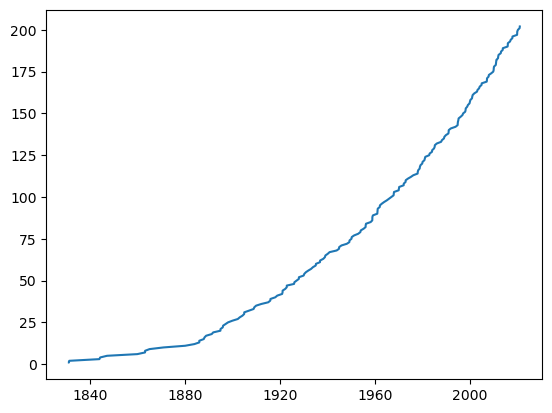

In [34]:
plt.plot(A['date'],A['id'])